# Random matrices

## Two batches

Libraries imported successfuly!


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


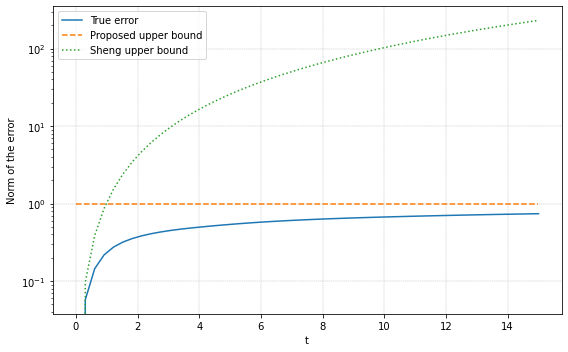

In [78]:
# Google Colab is required!
import time
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import expm
import scipy.linalg
import scipy.io as sio
import copy
import os
import urllib.request
urllib.request.urlretrieve('https://github.com/MerkulovDaniil/split-sgd/blob/master/Code/lls_data/fanlinear.mat', 'fanlinear.mat')
urllib.request.urlretrieve('https://github.com/MerkulovDaniil/split-sgd/blob/master/Code/lls_data/shepplogan.mat', 'shepplogan.mat')
np.random.seed(0)
print('Libraries imported successfuly!')

def generateRandomProblem(p, n):
  # Creating random X [n x p]
  X = np.random.randn(n, p)
  # Formula definition
  thetaTrue = np.ones(p)
  # Create y with noise
  y = X @ thetaTrue + 5e-1*np.random.randn(n) 
  theta_0 = np.random.randn(p)
  return X, theta_0, y

def loadTomDataTwoBatches(epsilon=1e-5):
    X = sio.loadmat(pjoin(os.path.abspath(os.curdir) ,'fanlinear.mat'))["A"].toarray()
    theta_true = sio.loadmat(pjoin(os.path.abspath(os.curdir) ,'shepplogan.mat'))["x"]
    n, p = X.shape
    y = np.squeeze(X @ theta_true)
    return X, theta_true, y

# creating [100 x 100]
p = 100
n = 100
# Batch count
N = 2
# Batch size
b = 50
# Generating random dataset
X, theta_0, y = generateRandomProblem(p,n)
# Load Tom  dataset - uncomment it
#X, theta_0, y = loadTomDataTwoBatches()

# Create batches
Xs = np.zeros((N, b, p))
ys = np.zeros((N, b))

# Fill batches with proper values
for i_batch in range(N):
  Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :] 
  ys[i_batch] = y[b*i_batch:b*(i_batch+1)]

# A = A1 + A2, A = −X.t() * X, Ai = −Xi.t() * Xi , i = 1,2
# for two batches, we create A1 and A2 depend on formulas above (splitting schema)
A1 = -1/n*Xs[0].T @ Xs[0]
A2 = -1/n*Xs[1].T @ Xs[1]

# Create equal distance variables from 0 to 15 (as default 50 variables created)
ts = np.linspace(0,15)

# Calculatin errors

## Sheng error (According to Sheng's paper)
## t is splitting step
## mu is the largest eigen vector of Hermitian matrix ((A + A.T)/2)
## logarithmic norm of commute of A (A1 @ A2 - A2 @ A1)
## (t**2)/2 * [A1,A2] - page 32
## [A1,A2] = logarithmic norm of commute * ((mu1+mu2)**t)
def shengError(t, A1, A2):
  w1, _ = np.linalg.eig((A1 + A1.T)/2)
  w2, _ = np.linalg.eig((A2 + A2.T)/2)
  mu1 = max(w1) 
  mu2 = max(w2) 
  return t**2/2 * np.linalg.norm(A1 @ A2 - A2 @ A1, ord=2) * np.exp((mu1 + mu2)*t)

## true error
## logarithmic norm of (sum(Ai)**t - (multiple of (Ai**t))
def trueError(t, A1, A2):
  return np.linalg.norm(expm((A1 + A2)*t) - expm(A1*t) @ expm(A2*t), ord=2)

sheng_errors = []
true_errors = []
for t in ts:
  sheng_errors.append(shengError(t, A1, A2))
  true_errors.append(trueError(t, A1, A2))

## Calculating constant
## Compute the qr factorization of batches' transposes
## || (I - Q1*Q1.T)(I - Q2*Q2.T) || 
def calculatedConstant(X1, X2):
  Q1, _ = np.linalg.qr(X1.T)
  Q2, _ = np.linalg.qr(X2.T)
  p, b = Q1.shape
  return np.linalg.norm((np.eye(p) - Q1@Q1.T)@(np.eye(p) - Q2@Q2.T), ord=2)

constant = calculatedConstant(Xs[0], Xs[1])
constants = []
for t in ts:
  constants.append(constant)

def plotErrors(errors_list, label_list, t):
    plt.figure(figsize = (8,5))
    linestyles = ['-', '--', ':', '-.']
    for errors, label, style in zip(errors_list, label_list, linestyles):
        plt.semilogy(t, errors, style, label=label)
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('Norm of the error')
    plt.grid(True, linestyle='--', linewidth=0.4)
    plt.tight_layout()
    plt.show()
plotErrors([true_errors, constants, sheng_errors], ['True error', 'Proposed upper bound','Sheng upper bound'], ts)


## Many batches

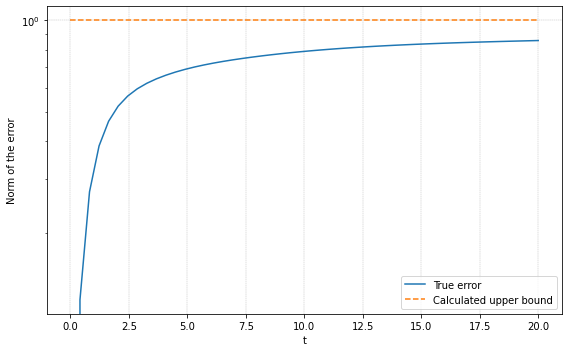

In [25]:
## After calculating for two batches, we can update our codes for multiple batches

# Google Colab is required!
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.linalg import expm
import copy
from random import shuffle
from tqdm import tqdm
import os
import urllib.request
urllib.request.urlretrieve('https://github.com/MerkulovDaniil/split-sgd/blob/master/Code/lls_data/fanlinear.mat', 'fanlinear.mat')
urllib.request.urlretrieve('https://github.com/MerkulovDaniil/split-sgd/blob/master/Code/lls_data/shepplogan.mat', 'shepplogan.mat')
np.random.seed(0)

# Generating batches(Xs) and splits(As) by X[p x n]
# s split count
def generateRandomProblem(p,n,s):
    X = np.random.randn(n, p)
    theta_clean = np.ones(p)
    y = X @ theta_clean + 5e-1*np.random.randn(n)
    theta_0 = np.random.randn(p)
    b = int(n // s)
    Xs = np.zeros((s, b, p))
    ys = np.zeros((s, b))
    As = []
    for i_batch in range(s):
      Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :] 
      ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
      As.append(-1/n*Xs[i_batch].T @ Xs[i_batch])
    return As, Xs

# Loadind LLS data
# s split count    
def loadTomDataMultipleBatches(s):
    X = sio.loadmat(pjoin(os.path.abspath(os.curdir) ,'fanlinear.mat'))["A"].toarray()
    theta_true = sio.loadmat(pjoin(os.path.abspath(os.curdir) ,'shepplogan.mat'))["x"]
    n, p = X.shape
    y = np.squeeze(X @ theta_true)
    b = int(n // s)
    Xs = np.zeros((s, b, p))
    ys = np.zeros((s, b))
    As = []
    for i_batch in range(s):
        Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :] 
        ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
        As.append(-1/n*Xs[i_batch].T @ Xs[i_batch])
    return As, Xs

p = 200
n = 200
s = 40
As, Xs = generateRandomProblem(p,n,s)
#As, Xs = loadTomDataMultipleBatches(s)



# Calculating true error
# Calculating true values by combining batches
# Calculating approximations
# Differentiation true values and approxs
# Logarithmic norm of this value is true error
def trueError(t, As):
  A = np.zeros(As[0].shape)
  approximation = np.eye(len(As[0]))
  for A_i in As:
    A += A_i
    approximation = approximation @ expm(A_i*t)
  true_solution = expm(A*t)
  return np.linalg.norm(true_solution - approximation, ord=2)

ts = np.linspace(0,20)
trueErrors  = []
for t in ts:
  trueErrors.append(trueError(t, As))


## Calculating constant
## Compute the qr factorization of batches' transposes
## || multiple of (I - Qi*Qi.T) || 
def calculatedConstant(Xs):
  b, p = Xs[0].shape
  error_product = np.eye(p)
  for X_i in Xs:
    Q_i, R_i = np.linalg.qr(X_i.T)
    projector_i = (np.eye(p) - Q_i@Q_i.T)
    error_product = error_product @ projector_i
  return np.linalg.norm(error_product, ord=2)

constant = calculatedConstant(Xs)
constants = []
for t in ts:
  constants.append(constant)


def plotErrors(errors_list, label_list, t, title=''):
    linestyles = ['-', '--', ':', '-.']
    plt.figure(figsize = (8,5))
    for errors, label, style in zip(errors_list, label_list, linestyles):
        plt.semilogy(t, errors, style, label=label)
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('Norm of the error')
    plt.grid(True, linestyle='--', linewidth=0.4)
    plt.tight_layout()
    plt.show()
plotErrors([trueErrors, constants], ['True error', 'Calculated upper bound'], ts, title=r'Linear System {} $\times$ {}, {} batches'.format(n,p,s))

